In [22]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import tensorflow as tf
import altair as alt
import collections



from src.load_data import read_tables
from src.CFModel import CFModel, build_CF_model, compute_scores, book_neighbors, user_recommendations
from src.Baseline_Model import build_baseline_model

### load data

In [10]:
# books, reviews = read_tables('data', )

In [11]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')

In [6]:
books.head(1)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837


In [7]:
reviews.head(1)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084


## Models

initially we wanted to use evaluation score: the mean of each user's top 5 recommended books' actual rating

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

we will use mse as evaluation score considering our dataset is sparse

### baseline model - global mean

baseline estimate for r_xi = u + b_x + b_i

u: global mean (overall mean book ratings)

b_x: rating deviation of user x = (avg. rating of user x) - u

b_i: rating deviation of book i = (avg. rating of book i) - u

In [12]:
train_mse, test_mse, eval_score = build_baseline_model(reviews) 
#print out train dataset mean rating to confirm each model uses the same training data

train_data mean rating: 3.80621


/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/Goodreads_Book_Recommender/src/Baseline_Model.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['prediction'] = np.zeros(len(reviews))


train mse: 15.53125 
 test_mse: 15.97210 
 evaluation_score: 3.86546


### CF model with adam optimizer

In [17]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05)

train_data mean rating: 3.80621


 iteration 600: train_error=0.009831, regularization_error=0.000000, gravity_loss=0.000000, test_error=17.298426

[{'train_error': 0.0098310765,
  'regularization_error': 0.0,
  'gravity_loss': 0.0,
  'test_error': 17.298426}]

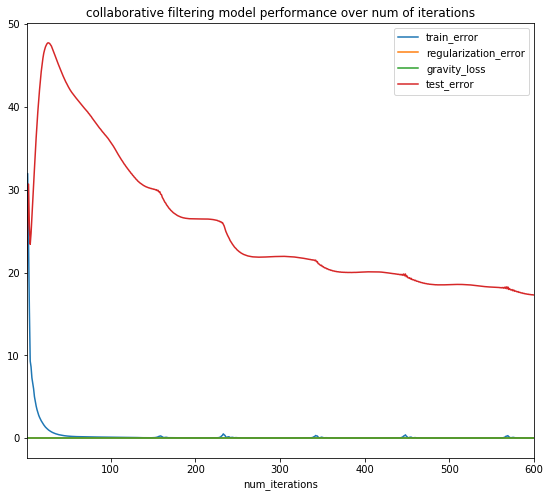

In [18]:
model_adam.train(num_iterations=600)

### CF model with regularization and adam optimizer

In [23]:
# A CFModel object that uses a regularized loss with adam optimizer
model_reg = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1)

train_data mean rating: 3.80621


 iteration 50: train_error=0.138551, regularization_error=0.749615, test_error=6.2327694

[{'train_error': 0.13855116,
  'regularization_error': 0.74961483,
  'test_error': 6.2327695}]

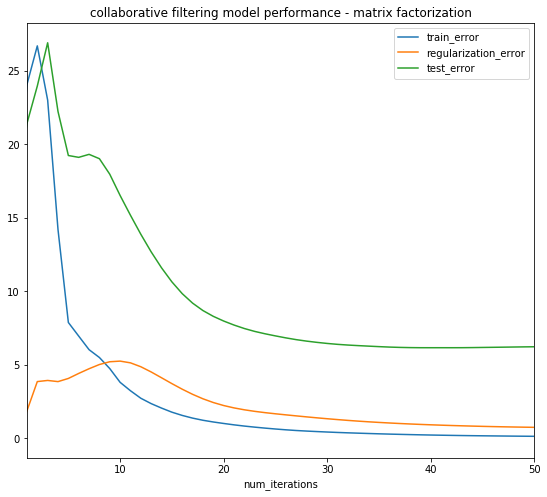

In [24]:
model_reg.train(num_iterations=50)

In [ ]:
# A CFModel object that uses a regularized loss, gravity loss with adam optimizer
model_reg_grv = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1,
                    gravity_coeff=0.1)

In [ ]:
model_reg_grv.train(num_iterations=50)

#### evaluation score is calculated based on  the mean of the top 5% recommended books' actual ratings

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

In [ ]:
eval_score(test_ratings, model_reg.embeddings['user_id'], model_reg.embeddings['book_id'] )

In [ ]:
# 85% of the users in test data only have 1 ratings
(test_ratings.user_id.value_counts() >1).sum()/len(test_ratings)

In [ ]:
# save model_embeddings
np.savez('model/model_reg_embeddings.npz', model_reg.embeddings['user_id'], model_reg.embeddings['book_id'])

In [ ]:
# load model_embeddings

# file = np.load('model/model_reg_embeddings.npz')
# user_embeddings = file['arr_0']
# book_embeddings = file['arr_1']

### Explore model_reg performance

#### get recommendations for a given user

In [25]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'fca26c34be8fe623ee340061f1281796'
sample_user_pred = user_recommendations(books, reviews, model_reg, user_id, measure='cosine', k=6)

The highest recommendations for user fca26c34be8fe623ee340061f1281796.


In [26]:
sample_user_pred.sort_values('cosine score', ascending=False)[:5]

,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count
56044,0.9146417379379272,Sweet Reason,0,3.43,7,4
2755,0.9038723111152649,Justification for Murder (The Darcy Lynch Seri...,1,3.96,532,49
30664,0.8967753052711487,The Nightingale Before Christmas (Meg Langslow...,0,4.02,1312,193
18932,0.8938353657722473,The Father's Child,1,3.6,29,12
24024,0.8845371603965759,Dear Mr. M,1,3.29,220,19


In [27]:
# explore the user_prediction (TODO: to delete later)


sample_user_pred = sample_user_pred.reset_index()

sample_user_pred.head()
sample_user_pred.columns = ['old_book_id', 'cosine score', 'titles', 'is_ebook', 'average_rating', 'ratings_count', 'text_reviews_count']

sample_user_actual = reviews[reviews.old_user_id == 'fca26c34be8fe623ee340061f1281796']

for_sample_user_model = sample_user_pred.merge(sample_user_actual, how='left', left_on='old_book_id', right_on = 'old_book_id')

user_df = reviews.groupby('old_user_id').count()['rating']
user_df.head()


In [34]:
(user_df.sort_values(ascending=False) > 30).sum()/len(user_df)

0.08478319995384603

### get neighbors of a book which contains a given substring

In [36]:
title_substring ='Crowner'
book_neighbors(books, reviews, model_reg, title_substring, measure='cosine', k=10)

Nearest neighbors of : Crowner's Crusade (Crowner John Mystery #15).
[Found more than one matching book. Other candidates: Crowner's Quest (Crowner John Mystery #3), The Poisoned Chalice (Crowner John Mystery #2), The Grim Reaper (Crowner John Mystery #6), The Elixir of Death (Crowner John Mystery #10), Figure of Hate (Crowner John Mystery #9), The Manor of Death (Crowner John Mystery #12), A Plague of Heretics (Crowner John Mystery #14), The Witch Hunter (Crowner John Mystery #8), The Sanctuary Seeker (Crowner John Mystery #1), Fear in the Forest (Crowner John Mystery #7), The Noble Outlaw (Crowner John Mystery #11)]


,cosine score,titles,is_ebook,average_rating,ratings_count
19563,0.9999998807907104,"Obsession (Faces of Evil, #1)",1,4.07,529
105305,0.9084354639053345,Pronto,0,3.74,5579
100513,0.8990375995635986,The Smell of the Night (The Inspector Montalba...,1,3.98,137
26365,0.889642596244812,An Aria of Omens,1,3.98,152
11662,0.8789119124412537,The Dead List,1,3.83,138
60481,0.8784198760986328,Sticks and Stones (Randy Craig Mystery #2),0,3.78,39
69502,0.8780992031097412,Shrouded In Thought (Victorian Chicago Mystery...,1,3.84,28
28117,0.8731884956359863,Song of Solomon,0,4.29,108
50449,0.8725510835647583,The Thief,0,3.51,2477
56953,0.8719014525413513,A Taste for Death (Adam Dalgliesh #7),0,4.01,8983


### inspect neighbor clustering

In [37]:
def book_embedding_norm(books, models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': books['title'],
        'average_rating': books['average_rating'],
        'ratings_count':books['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1) #only included the first 1000 books for visualization
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df[:1000])
    
    

In [38]:
def visualize_movie_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(is_ebook_filter, "is_ebook", alt.value("whitesmoke")),
      ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), is_ebook_chart, data=data[:5000])


In [39]:
is_ebook_filter = alt.selection_multi(fields=['is_ebook'])
is_ebook_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('is_ebook'),
    color=alt.condition(
        is_ebook_filter,
        alt.Color("is_ebook:N"),
        alt.value('lightgray'))
).properties(height=300, selection=is_ebook_filter)

In [40]:
def tsne_movie_embeddings(model, books):
    """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model.embeddings["book_id"][:5000])
    books.loc[:,'x'] = V_proj[:, 0]
    books.loc[:,'y'] = V_proj[:, 1]
    return visualize_movie_embeddings(books, 'x', 'y')

In [42]:
model_reg.embeddings['book_id'].shape, len(books)

((105365, 30), 105365)

In [45]:
book_embedding_norm(books, model_reg)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
